In [1]:
from ipynb.fs.full.my_functions import process_data, train_models, CV, predict, metric, param_selection, best_params, errors
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import shap
#shap.initjs()
plt.rcParams["figure.figsize"] = (20,5)

In [2]:
# Split data
features = ['Gen_RPM', 'Gen_Phase_Temp', 'Nac_Temp', 'Wind_Speed', 'Humidity']
target = 'Gen_Bear_Temp'

df = pd.read_pickle("modeling.pkl")

train = df.loc[:'2016'].copy()
test = df.loc['2017':].copy()

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [ ]:
# Save df as pickle
df = process_data()
df.to_pickle("modeling.pkl")

In [ ]:
# Use to find errors in my_functions notebook
%run my_functions.ipynb

In [ ]:
bins = [0, 1200, 1300, 1600, 1700]
s = df.groupby(pd.cut(df['Gen_RPM'], bins=bins)).size()
print (s)

# Plotting data splits

In [ ]:
# Plot train/test split
fig, ax = plt.subplots(figsize=(15,7))
train.Gen_Bear_Temp.plot(ax=ax, label='Training Set')
test.Gen_Bear_Temp.plot(ax=ax, label='Test Set')
ax.axvline('2017', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
ax.set_ylabel('Temperature ($^\circ$C)')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

#plt.savefig(r'figs\train_test_split.png', bbox_inches='tight')
plt.show()

In [ ]:
# Plot train/validation/test split
train_short = df.loc[df.index < '2016-09']
cv = df.loc[(df.index >= '2016-09') & (df.index < '2017')]

fig, ax = plt.subplots(figsize=(15,7))
train_short.Gen_Bear_Temp.plot(ax=ax, label='Training Set')
cv.Gen_Bear_Temp.plot(ax=ax, label='Cross Validation Set')
test.Gen_Bear_Temp.plot(ax=ax, label='Test Set')
ax.axvline('2017', color='black', ls='--')
ax.axvline('2016-09', color='black', ls='--')
ax.legend(['Training Set', 'Validation Set', 'Test Set'])
ax.set_ylabel('Temperature ($^\circ$C)')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

plt.savefig(r'figs\train_val_test_split.png', bbox_inches='tight')
plt.show()

In [ ]:
# Plot cross validation folds
tss = TimeSeriesSplit(n_splits=4, test_size=6*24*30, gap=6*24)

fig, axs = plt.subplots(4, 1, figsize=(15, 10), sharex=True)

cv_df = df.loc[df.index < '2017'].copy()

fold = 0
for train_idx, val_idx in tss.split(cv_df):
    train = cv_df.iloc[train_idx]
    test = cv_df.iloc[val_idx]
    train['Gen_Bear_Temp'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Gen_Bear_Temp'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    axs[fold].xaxis.set_major_locator(mdates.MonthLocator())

    fold += 1

plt.savefig(r'figs\folds.png', bbox_inches='tight')    
plt.show()

# Training and cv

In [3]:
# Train models
models = train_models(X_train, y_train)

5.46869158744812


In [ ]:
# Cross-validate NaN-compatible models
CV(df, models, features, target)

# Predictions

In [4]:
# Predicting and adding predictions to main dataframe
df = predict(X_test, df, models)

0.14991331100463867


In [ ]:
# Make custom prediction with features in following order: 
#'Gen_RPM', 'Gen_Phase_Temp', 'Nac_Temp', 'Wind_Speed', 'Amb_temp'
models[0].predict(np.array([0, 140, 70, 19, 47]).reshape(1,-1))

# Metrics

In [ ]:
plt.scatter(df.loc[start:end][feature_1], df.loc[start:end][feature_2])
plt.show()

In [ ]:
start = '2016'
end = '2017'

feature_1 = 'Gen_RPM'
feature_2 = 'Wind_Speed'

ax = df.loc[(df.index > start) & (df.index < end)][feature_1] \
    .plot(title='Power vs Wind Speed', label=feature_1, ylabel='W', legend=True)

df.loc[(df.index > start) & (df.index < end)][feature_2] \
    .plot(secondary_y=True, label=feature_2, ylabel='m/s', ax=ax, legend=True)

plt.show()

In [5]:
# Add metrics to dataframe
metrics = metric(df, models, target)

In [6]:
metrics

MAE    MAPE     MSE    RMSE      R2
XGB  1.4345  0.0348  4.2955  2.0725  0.9804

In [ ]:
# Plot metrics
ax = metrics.T.plot(kind='bar', title='Metric Scores', xlabel='Metric', ylabel='Score', width=0.8)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005), rotation=45)

plt.xticks(rotation=0)
plt.show()

# Plotting predicted and actual values

In [ ]:
import datetime as dt

In [ ]:
# Plot real value vs predicted values
start = '2017-07-15'
end = '2017-09-15'

fig, ax = plt.subplots(figsize=(15,7))

SD = np.std(df['XGB'] - df['Gen_Bear_Temp'])

ax = df[start:end]['Gen_Bear_Temp'].plot(lw=2, label='Actual', x_compat=True)
df[start:end]['XGB'].plot(style='-', lw=1.2, label='Predicted')
#df.loc[(df.index > start) & (df.index < end)]['Pip'].plot(style='.', ms=4)
# df.loc[(df.index > start) & (df.index < end)]['Ran'].plot(style='.')
# df.loc[(df.index > start) & (df.index < end)]['Lin'].plot(style='.')
# (df[start:end]['XGB'] + 2*SD).plot(style='-', lw=1.2, label='Predicted + 2SD')
# (df[start:end]['XGB'] - 2*SD).plot(style='-', lw=1.2, label='Predicted - 2SD')


ax.set_ylim(0,100)
ax.set_ylabel('Temperature ($^\circ$C)')
#ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
#ax.set_xlim(ax.get_xlim()[0] - 200, ax.get_xlim()[1] + 0)
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
#ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
#ax.axvline('2017-08-27 07:20:00', color='black', ls='--', lw=1)
#ax.set_xlim(ax.get_xlim()[0] - 1, ax.get_xlim()[1] + 0)
# ax.axvspan('2017-06-07 21:20:00', '2017-06-08 03:00:00', color="green", alpha=0.3) 
#ax.axvspan('2017-08-20 07:50', '2017-08-28 22:10', color="green", alpha=0.3) 

# time = '2017-01-07 17:40:00'
# ax.annotate(time,
#             xy=(time, df.loc[time]['Gen_Bear_Temp']),
#             xytext=(50, 70), textcoords='offset points',
#             ha='center', va='bottom',
#              bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.4),
#             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', 
#                             color='black', lw=2))

# time = '2017-06-07 23:10:00'
# ax.annotate(time,
#             xy=(time, df.loc[time]['Gen_Bear_Temp']),
#             xytext=(-130, -50), textcoords='offset points',
#             ha='center', va='bottom',
#              bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.4),
#             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', 
#                             color='black', lw=2))

# time = '2017-08-27 07:20:00'
# ax.annotate(time,
#             xy=(time, df.loc[time]['XGB']),
#             xytext=(-30, 120), textcoords='offset points',
#             ha='center', va='bottom',
#              bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.4),
#             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', 
#                             color='black', lw=2))

# time = '2017-08-20 07:50'
# ax.annotate(time,
#             xy=(time, df.loc[time]['XGB']),
#             xytext=(-100, 70), textcoords='offset points',
#             ha='center', va='bottom',
#              bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.4),
#             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', 
#                             color='black', lw=2))

for label in ax.get_xticklabels(which='major'):
    label.set(rotation=0, horizontalalignment='center')

plt.legend()
#plt.savefig('figs\preds_aug.png', bbox_inches='tight')
plt.show()

In [ ]:
pd.set_option('display.max_rows', 500)

In [ ]:
# df.query('XGB + 2*@SD < Gen_Bear_Temp').head(500)

In [ ]:
# Calculate error and show timestamps of largest errors
df = errors(df, models, target)

In [ ]:
df['error_XGB'].sort_values(ascending=False).head(20)

In [ ]:
df['2017-03-14 12:10':'2017-03-14 13:40']

In [ ]:
model = models[6]

print("Model coefficients:\n")
for i in range(X_train.shape[1]):
    print(X_train.columns[i], "=", model.coef_[i].round(5))

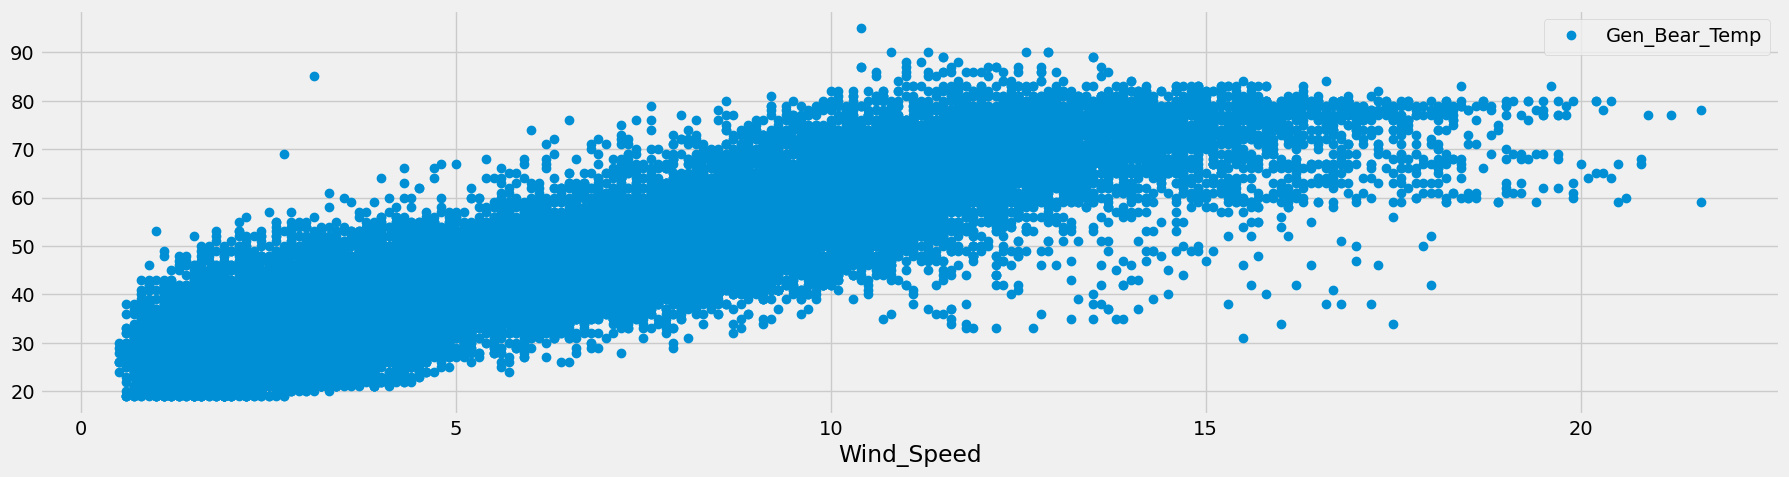

In [33]:
start = '2016'
end = '2017'

df.loc[(df.index > start) & (df.index < end)].plot(
    x='Wind_Speed', y='Gen_Bear_Temp', style='o')

plt.show()

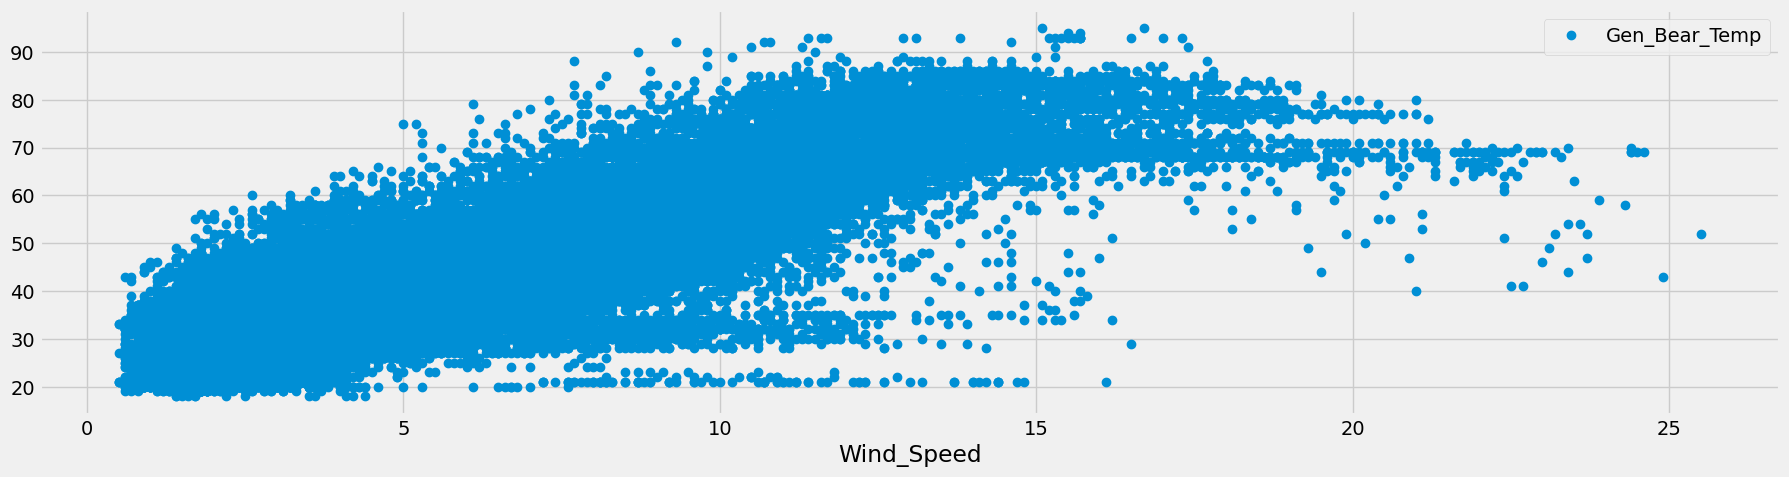

In [35]:
start = '2017'
end = '2018'

df.loc[(df.index > start) & (df.index < end)].plot(
    x='Wind_Speed', y='Gen_Bear_Temp', style='o')

plt.show()

# Hyperparameter tuning

In [ ]:
# GridSearch to tune hyperparameters of selected model
model = models[0]
param_grid = param_selection(model)
scores = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']

tss = TimeSeriesSplit(n_splits=4, test_size=6*24*30, gap=6*24)
search = GridSearchCV(model, param_grid, cv=tss, verbose=3, n_jobs=-1, scoring=scores, refit='r2')

grid = best_params(X_train, y_train, search)
grid

In [ ]:
grid.to_pickle("param_tuning.pkl")

In [ ]:
grid = pd.read_pickle("param_tuning.pkl")

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(11,9))

y2_ticks = [0.975, 0.98, 0.985, 0.99, 0.995, 1]
#[0.970, 0.974, 0.978, 0.982, 0.986, 0.99]

cv_results = abs(grid.loc[
    (grid['param_max_depth'] == 5) & (grid['param_n_estimators'] == 800) # learning_rate
][[
    'param_learning_rate', 'param_max_depth', 'param_n_estimators', 'mean_test_neg_mean_absolute_error', 
    'mean_test_neg_mean_squared_error', 'mean_test_r2']])

N_est = cv_results.param_learning_rate
R2 = cv_results.mean_test_r2
RMSE = np.sqrt(cv_results.mean_test_neg_mean_squared_error)
MAE = cv_results.mean_test_neg_mean_absolute_error

lns1 = ax[0,0].plot(N_est, RMSE, '-o', label = 'RMSE', lw=2, color='b')
lns2 = ax[0,0].plot(N_est, MAE, '-o', label = 'MAE', lw=2, color='r')
ax2 = ax[0,0].twinx()
lns3 = ax2.plot(N_est, R2, '-o', label = 'R2', lw=2, color='g')

lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax[0,0].legend(lns, labs, loc='best')

ax[0,0].set_xlabel('learning_rate', fontsize=16)
ax[0,0].set_ylabel('Error', fontsize=16)
ax[0,0].set_ylim(1,2)
#ax2.set_ylim(0.965,0.99)
ax2.set_yticks(y2_ticks)
ax[0,0].set_xlim(0,0.11)
ax[0,0].set_xticks([0.01, 0.05, 0.1])
ax2.set_ylabel('R2')


cv_results = abs(grid.loc[
    (grid['param_learning_rate'] == 0.05) & (grid['param_n_estimators'] == 800) # max_depth
][[
    'param_learning_rate', 'param_max_depth', 'param_n_estimators', 'mean_test_neg_mean_absolute_error', 
    'mean_test_neg_mean_squared_error', 'mean_test_r2']])

N_est = cv_results.param_max_depth
R2 = cv_results.mean_test_r2
RMSE = np.sqrt(cv_results.mean_test_neg_mean_squared_error)
MAE = cv_results.mean_test_neg_mean_absolute_error

lns1 = ax[0,1].plot(N_est, RMSE, '-o', label = 'RMSE', lw=2, color='b')
lns2 = ax[0,1].plot(N_est, MAE, '-o', label = 'MAE', lw=2, color='r')
ax2 = ax[0,1].twinx()
lns3 = ax2.plot(N_est, R2, '-o', label = 'R2', lw=2, color='g')

lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax[0,1].legend(lns, labs, loc='best')

ax[0,1].set_xlabel('max_depth', fontsize=16)
ax[0,1].set_ylabel('Error', fontsize=16)
ax[0,1].set_ylim(1,2)
ax2.set_yticks(y2_ticks)
#ax2.set_ylim(0.98, 0.99)
ax[0,1].set_xlim(2,10)
ax[0,1].set_xticks([3, 4, 5, 6, 7, 8, 9])
ax2.set_ylabel('R2')


cv_results = abs(grid.loc[
    (grid['param_max_depth'] == 5) & (grid['param_learning_rate'] == 0.05) # n_estimators
][[
    'param_learning_rate', 'param_max_depth', 'param_n_estimators', 'mean_test_neg_mean_absolute_error', 
    'mean_test_neg_mean_squared_error', 'mean_test_r2']])

N_est = cv_results.param_n_estimators
R2 = cv_results.mean_test_r2
RMSE = np.sqrt(cv_results.mean_test_neg_mean_squared_error)
MAE = cv_results.mean_test_neg_mean_absolute_error

lns1 = ax[1,0].plot(N_est, RMSE, '-o', label = 'RMSE', lw=2, color='b')
lns2 = ax[1,0].plot(N_est, MAE, '-o', label = 'MAE', lw=2, color='r')
ax2 = ax[1,0].twinx()
lns3 = ax2.plot(N_est, R2, '-o', label = 'R2', lw=2, color='g')

lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax[1,0].legend(lns, labs, loc='best')
ax[1,0].set_xlabel('n_estimators', fontsize=16)
ax[1,0].set_ylabel('Error', fontsize=16)
ax[1,0].set_ylim(1,2)
#ax2.set_ylim(0.97, 0.99)
ax2.set_yticks(y2_ticks)
ax[1,0].set_xlim(100,1100)
ax2.set_ylabel('R2')

ax[1,0].title.set_text('(C)')
ax[0,1].title.set_text('(B)')
ax[0,0].title.set_text('(A)')

ax[1][1].set_visible(False)
ax[0,0].set_box_aspect(1)
ax[0,1].set_box_aspect(1)
ax[1,0].set_box_aspect(1)

plt.tight_layout()
plt.savefig(r'figs\hyp_tuning.png', bbox_inches='tight')
plt.show()

# Residuals

In [ ]:
columns =  ['Lin', 'Ran', 'Pip', 'XGB']
labels = ['LR', 'RF', 'SVR', 'XGBoost']

fig, ax = plt.subplots(figsize=(15,8))

i = 0
for col in columns:
    ax = sns.residplot(x=y_test, y=df.query('index >= 2017')[col], scatter_kws={'alpha':0.5}, label=labels[i])
    i += 1

ax.set_ylim(-30,30)
plt.ylabel('Residuals')
plt.legend()
plt.savefig(r'figs\residuals_all.png', bbox_inches='tight')
plt.show()

In [ ]:
fig, ax = plt.subplots(4,1, figsize=(15,20), sharey=True)
columns =  ['Lin', 'Ran', 'Pip', 'XGB']
labels = ['LR', 'RF', 'SVR', 'XGBoost']

for idx, col in enumerate(columns):
    sns.residplot(x=y_test, y=df.query('index >= 2017')[col], scatter_kws={'alpha':0.3}, ax=ax[idx], label=labels[idx])
    ax[idx].legend()
    ax[idx].set_ylim(-30,30)
    ax[idx].set_ylabel('Residuals')

plt.savefig(r'figs\residuals_ind.png', bbox_inches='tight')
plt.show()

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))
true_value = y_test
labels = ['LR', 'RF', 'SVR', 'XGBoost']
for idx, model in enumerate(models):
    model = str(model)[:3]
    plt.subplot(2, 2, idx+1)
    predicted_value = df[model].loc[df[model].notna()]
    lo = plt.scatter(true_value, predicted_value, c='crimson', alpha=0.3, lw=0.001, label=labels[idx])

    p1 = max(max(predicted_value), max(true_value))
    p2 = min(min(predicted_value), min(true_value))
    plt.plot([p1, p2], [p1, p2], 'b--', label='Perfect agreement (R2=1)')
    plt.xlabel('Observed Temperature ($^\circ$C)')
    plt.ylabel('Predicted Temperature ($^\circ$C)')
    plt.gca().set_xlim(10,110)
    plt.gca().set_ylim(10,110)
    plt.gca().set_aspect('equal')
    plt.legend()

plt.savefig(r'figs\perf_agr.png', bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=(8,8))
true_value = y_test
predicted_value = df['XGB'].loc[df['XGB'].notna()]
plt.scatter(true_value, predicted_value, c='crimson', alpha=0.4, lw=0.001)

p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b--')
plt.xlabel('Observed Bearing Temperature ($^\circ$C)')
plt.ylabel('Predicted Bearing Temperature ($^\circ$C)')
plt.axis('equal')
plt.show()

In [ ]:
names = [
         "Wind speed", "Generator RPM", "Humidity",
         "Nacelle temperature", "Generator phase temperature",
]
g = graphviz.Digraph()
for name in names:
    g.node(name, fontsize="10")
g.node("Generator bearing temperature", style="filled", fontsize="10")

g.edge("Wind speed", "Generator RPM")
g.edge("Generator RPM", "Generator phase temperature")
g.edge("Generator RPM", "Generator bearing temperature")
g.edge("Generator phase temperature", "Generator bearing temperature")
g.edge("Nacelle temperature", "Generator bearing temperature")
g.edge("Humidity", "Generator bearing temperature")

g

In [ ]:
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances = feat_importances.sort_values()

plt.barh(feat_importances.index, feat_importances.values)
plt.xlabel('Share of total feature importance')
plt.show()

# SHAP
### Global Explanation

In [37]:
model = models[0]
sample = X_test
#sample = shap.sample(X_test, 5000, random_state=42)
explainer = shap.TreeExplainer(model)
shap_values = explainer(sample)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [ ]:
# summary plot
shap.summary_plot(shap_values, sample, show=False)
plt.xlabel("SHAP value")
#plt.savefig(r'figs\shap_summary.png', bbox_inches='tight')
plt.show()

In [ ]:
# summary plots
fig, axs = plt.subplots(1,2, figsize=(13,5))

plt.subplot(1,2,1)
shap.summary_plot(shap_values, sample, plot_type='bar', plot_size=None, show=False)
axs[0].set_xlabel("Mean absolute SHAP value")
axs[0].set_title('(A)')

plt.subplot(1,2,2)
shap.summary_plot(shap_values, sample, alpha=0.05, plot_size=None, show=False)
axs[1].set_xlabel("SHAP value")
axs[1].set_title('(B)')

#plt.savefig(r'figs\shap_bee_bar.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

In [ ]:
# bar summary plot
#clust = shap.utils.hclust(X_test, y_test, linkage="single", random_state=42)
shap.plots.bar(shap_values, 
               #clustering=clust, 
               #clustering_cutoff=0, 
               show=False)
plt.xlabel('mean absolute SHAP value')
plt.savefig(r'figs\shap_summary_bar.png', bbox_inches='tight')
plt.show()

In [ ]:
# scatter plot with colored interactions
fig, ax = plt.subplots(3,2, sharey=True)
axes = ax.ravel()
titles = ['(A)', '(B)', '(C)', '(D)', '(E)']

for idx, col in enumerate(X_test.columns):
    shap.dependence_plot(col, shap_values.values, X_test, alpha=0.5, ax=axes[idx], show=False)    
    axes[idx].set_title(titles[idx])

ax[2][1].set_visible(False)
plt.gcf().set_size_inches(13,10)
plt.tight_layout()
plt.savefig(r'figs\shap_w_ix.png', bbox_inches='tight')
plt.show()

### Interactions

In [ ]:
X_interaction = X_test#shap.sample(X_test, 5000, random_state=42)
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X_interaction)

In [ ]:
shap.summary_plot(shap_interaction_values, X_interaction, show=False)
plt.gcf().set_size_inches(25,8)
plt.show()

In [ ]:
# main effect plot
fig, ax = plt.subplots(3,2, sharey=True)
axes = ax.ravel()
titles = ['(A)', '(B)', '(C)', '(D)', '(E)']

for idx, col in enumerate(X_test.columns):
    shap.dependence_plot((col, col), shap_interaction_values, X_interaction, alpha=0.5, ax=axes[idx], show=False) 
    axes[idx].set_title(titles[idx])

ax[2][1].set_visible(False)
plt.gcf().set_size_inches(13,10)
plt.tight_layout()
#plt.savefig(r'figs\shap_main_effect.png', bbox_inches='tight')
plt.show()

In [ ]:
# interaction between two and two features
feature = 'Gen_RPM'
cols = X_test.columns.drop(feature)
titles = ['(A)', '(B)', '(C)', '(D)', '(E)']

fig, ax = plt.subplots(2,2, sharey=True)
axes = ax.ravel()

for idx, col in enumerate(cols):
    shap.dependence_plot((feature, col), shap_interaction_values, X_interaction, ax=axes[idx], show=False)
    axes[idx].set_title(titles[idx])

plt.gcf().set_size_inches(13,8)
plt.tight_layout()
plt.show()

### Local explanation

In [ ]:
sample = X_test
model = models[0]
explainer = shap.TreeExplainer(model)
shap_values = explainer(sample)

In [ ]:
y_test[970]

In [ ]:
X_test.iloc[970]

In [ ]:
X_test.index.get_loc('2017-01-07 16:00:00')

In [ ]:
y_test.iloc[22724]

In [ ]:
y_test.iloc[34083]

In [ ]:
explainerr = shap.Explainer(model)
shap_valuess = explainer.shap_values(X_test)

In [ ]:
shap.initjs()
shap.force_plot(explainerr.expected_value, shap_valuess[34083,:], features=X_test.columns)

In [ ]:
fig, ax = plt.subplots(figsize=(13,5))
shap.plots.waterfall(shap_values[970], show=False)

plt.savefig(r'figs\waterfall_jan.png', bbox_inches='tight')
plt.show()

In [ ]:
expected_value = explainer.expected_value
sv = explainer(shap.sample(X_test, 500))

fig, ax = plt.subplots(figsize=(13,5))

#plt.subplot(1,2,1)
shap.plots.decision(expected_value, sv.values, features=X_test.columns, alpha=0.1, show=False)
plt.savefig(r'figs\decisions_plot.png', bbox_inches='tight')
plt.show()

# ICE

In [18]:
from pycebox.ice import ice, ice_plot

In [19]:
features = X_test.columns
col_by = features
#model = models[0]
sample = X_test

sample_short = shap.sample(sample, 50, random_state=42)

fig, axs = plt.subplots(5, 2, figsize=(12,25))


for idx, feature in enumerate(features):
    ice_df = ice(sample_short, feature, model.predict, num_grid_points=None)

    ice_plot(ice_df, linewidth=.5, #plot_points=True,
             color_by=col_by[idx-1], plot_pdp=True,
             pdp_kwargs={'c': 'blue', 'linewidth': 5}, 
             frac_to_plot=1, ax=axs[idx,0])

    axs[idx,0].set_xlabel(feature)
    axs[idx,0].set_ylabel('Gen_Bear_Temp')
#    axs[idx,0].set_ylim(18, 95)

    ice_plot(ice_df, linewidth=.5,
             color_by=col_by[idx-1], plot_pdp=True, #plot_points=True,
             pdp_kwargs={'c': 'blue', 'linewidth': 5},
             frac_to_plot=1, ax=axs[idx,1], 
             centered=True, cmap='coolwarm')
    if feature == 'Nac_Temp':
        axs[idx,1].set_ylim(0, 20)
    axs[idx,1].set_xlabel(feature)
    axs[idx,1].set_ylabel('Change in Gen_Bear_Temp')
    
#fig.suptitle('ICE Curves', fontsize=20, fontweight='bold')

#ice_ax_centered.set_title('ICE Curves');
plt.savefig('Ice_curves.jpg', bbox_inches='tight')
plt.show()

iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


# ALE

In [ ]:
from PyALE import ale
## two 1D plots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ale_res_1 = ale(
    X=X_test[features],
    model=models[0],
    feature=["Gen_Phase_Temp"],
    feature_type="continuous",
    grid_size=20,
    include_CI=True,
    C=0.99,
    plot=True,
    fig=fig,
    ax=ax1,
)
ale_res_2 = ale(
    X=X_test[features],
    model=models[0],
    feature=["Nac_Temp"],
    feature_type="continuous",
    grid_size=20,
    include_CI=True,
    C=0.95,
    plot=True,
    fig=fig,
    ax=ax2,
)
# change x labels
ax1.set_xlabel("Temperature")
ax2.set_xlabel("RPM")
plt.show()

In [ ]:
# Plot two features and show their combiined effect on prediction
ale_eff = ale(X=X_test, model=models[0], feature=["Gen_Phase_Temp", "Gen_RPM"])

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df.Wind_Speed, lags=23, missing='drop', title='Wind Speed Autocorrelation')

from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df.Wind_Speed, lags=23, title='Wind Speed Partial Autocorrelation')

## dtreeviz

### Some lines are commented out due to them requiring a lot of CPU

In [ ]:
import dtreeviz
import graphviz

model = models[0]
viz_rmodel = dtreeviz.model(model,
                           X_train, y_train,
                           feature_names=features,
                           target_name=target,
                           tree_index=1                        
                          )

# viz_rmodel.view(fancy=False)

In [ ]:
x = X_train.iloc[900]
x

In [ ]:
viz_rmodel.view(show_just_path=True, x = x)

In [ ]:
from sklearn.tree import DecisionTreeRegressor 
from sklearn import tree

clf = tree.DecisionTreeRegressor(random_state=0)

clf = clf.fit(X_train[:15], y_train[:15])
tree.plot_tree(clf, feature_names=features, class_names=target, filled=True, impurity=False, rounded=True, precision=1)
plt.show()

In [ ]:
# viz_rmodel.view(x = x)

In [ ]:
print(viz_rmodel.explain_prediction_path(x))

In [ ]:
viz_rmodel.leaf_sizes()

In [ ]:
viz_rmodel.rtree_leaf_distributions()

In [ ]:
viz_rmodel.node_stats(node_id=4)

# Lime

In [ ]:
# 22724 34083

In [6]:
import lime
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.dropna().values, feature_names=X_train.columns.values.tolist(),
                                                  class_names=[target], verbose=True, mode='regression')

In [15]:
j = 34083
exp = explainer.explain_instance(X_test.values[j], model.predict, num_features=len(features))

Intercept 47.87560908089114
Prediction_local [35.69755797]
Right: 53.911465


In [16]:
exp.show_in_notebook(show_table=True)

In [17]:
exp.as_list()

[('Gen_Phase_Temp <= 43.00', -19.581162919625324),
 ('Gen_RPM <= 282.82', 3.1635542823224276),
 ('Wind_Speed > 8.00', 2.9748700700317046),
 ('28.00 < Nac_Temp <= 33.00', 0.9899458968714541),
 ('59.00 < Humidity <= 71.00', 0.2747415552203596)]

In [12]:
j = 22724
exp = explainer.explain_instance(X_test.values[j], model.predict, num_features=len(features))

Intercept 37.79086786198879
Prediction_local [65.82153767]
Right: 76.500694


In [13]:
exp.show_in_notebook(show_table=True)

In [14]:
exp.as_list()

[('Gen_Phase_Temp > 78.70', 23.385773663573694),
 ('Nac_Temp > 33.00', 4.901689563463651),
 ('Gen_RPM > 1582.10', -2.614776036052418),
 ('Wind_Speed > 8.00', 2.484490528941587),
 ('Humidity <= 59.00', -0.12650791238466647)]

In [ ]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
predictions = model.predict(X_test)

dt = DecisionTreeRegressor(random_state = 100, max_depth=3)
dt.fit(X_test, predictions)

fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(dt, feature_names=list(X_test.columns), precision=3, 
           filled=True, fontsize=12, impurity=True)
plt.show()

In [ ]:
dt.score(X_test, predictions)

In [ ]:
fig, ax = plt.subplots(figsize=(25, 10))
features = ['Gen_RPM', 'Gen_Phase_Temp', ('Gen_RPM', 'Gen_Phase_Temp')]
PartialDependenceDisplay.from_estimator(LGB, X_train[:100], features, ax=ax)
fig.suptitle('Partial Dependence Plots')
fig.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(25, 15))
PartialDependenceDisplay.from_estimator(model, X_train[:100], features,
    kind='both', ax=ax, n_cols=1
                                       )
plt.show()

In [ ]:
var = 'Gen_RPM'
values = X_train[var].sort_values().unique()

In [ ]:
n_cols = 2
n_rows = int(len(X_train.columns)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(10, 12))
PartialDependenceDisplay.from_estimator(XGB, X_train[:100], X_train.columns, ax=ax, n_cols=n_cols)
fig.suptitle('Partial Dependence Plots')
fig.tight_layout()
plt.show()

# Explainerdashboard

In [ ]:
from explainerdashboard import RegressionExplainer, ExplainerDashboard

In [ ]:
model = model
explainer = RegressionExplainer(model, X_test[:1000], y_test[:1000],
                                target='Gen_Bear_Temp',
                                precision='float32')

db = ExplainerDashboard(explainer,title='WT Bearing Temperature Prediction', mode='external', )

In [ ]:
db.run()

In [ ]:
ExplainerDashboard.terminate(8050)

In [ ]:
#db.to_yaml("dashboard.yaml", explainerfile="explainer.joblib", dump_explainer=True)
db = ExplainerDashboard.from_config("dashboard.yaml")
db.run()